In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# constants
dH_1 = -74.32*1000 # kBTU/lbmol
dH_2 = -474.57*1000 # kBTU/lbmol
dp = 0.25/12 # ft
dt = 1/12 # ft
L = 20 # ft
e_b = 0.5
NT = 2500 # tubes
W = 100000 # lbmol/hr
Fc_Cpc = 10**6 # BTU/hr/C
rho_B = 100 # lb/ft^3
mu = 0.048/60/60 # lb/ft/hr
Cp = 0.5 # BTU/lbmol/C
U = 120.5 # BTU/hr/ft^2/C
k1 = 1.771*10**(-3)
k2 = 23295.0
k3 = 0.5
k4 = 1.0
k5 = 0.8184
k6 = 0.5
k7 = 0.2314
k8 = 1
k9 = 1.25
k10 = 2
k11 = 2.795*10**(-4)
k12 = 33000
k13 = 0.5
k14 = 2
R = 10.73/(5/9) # BTU/lbmol/C

# elements list
elements = ['DT', 'VA', 'O2', 'CO2', 'H2O', 'N2']
MW = [46, 44, 32, 44, 18, 28]

# initial conditions
P_T0 = 114.7 # psia
T_R0 = 353 # K
Xi_0 = [.1, 0, 0.07, 0, 0.02]
MW_0 = Xi_0[0]*MW[0] + Xi_0[2]*MW[2] + Xi_0[4]*MW[4] + (1-sum(Xi_0))*MW[-1]# lbmol/lbcat

# calculated constants
Ac = np.pi*(dt/2)**2 # ft^2

# define T horizon
dz = np.linspace(.2, L, 100)

In [3]:
# ode fxn
def odes(y, z, code):
    # retrieve updated variables
    X1 = y[0]
    X2 = y[1]
    X3 = y[2]
    X4 = y[3]
    X5 = y[4]
    T_R = y[5]
    T_C = y[6]
    MW_bar = y[7]
    P_T = y[8]

    # Partial Pressures --> ok
    P_O2 = P_T*X3 # lbmol/lbcat
    P_DT = P_T*X1 # lbmol/lbcat
    P_VA = P_T*X2 # lbmol/lbcat

    # rate equations --> ok
    RT = (1/T_R - 1/373)/1.987
    r1 = k1*np.exp(-k2*RT)*P_O2**k3*P_DT**k4/(1+k5*P_O2**k6+k7*P_DT**k8+k9*P_VA**k10) # lbmol/lbcat/hr
    r2 = k11*np.exp(-k12*RT)*P_O2**k13*P_VA**k14/(1+k5*P_O2**k6+k7*P_DT**k8+k9*P_VA**k10) # lbmol/lbcat/hr

    R_i = {'DT': -r1, 'VA': r1-r2, 'O2': -r1/2 - 5*r2/2, 'CO2': 2*r2, 'H2O': r1 + 2*r2, 'N2': 0} # ok

    # given eqs --> ok
    u = 359*14.7*W*T_R/(273*3600*NT*Ac*MW_bar*P_T)
    a = 1 + 2*dp/(3*(1-e_b)*dt)

    # differential equations --> ok
    dMWdz = MW_bar**2*NT*Ac*rho_B*((-28+MW[0])*R_i['DT'] + (-28+MW[1])*R_i['VA'] + (-28+MW[2])*R_i['O2'] + (-28+MW[3])*R_i['CO2']+ (-28+MW[4])*R_i['H2O'])/(W*(MW_bar+28*(X1+X2+X3+X4+X5)-MW[0]*X1-MW[1]*X2-MW[2]*X3-MW[3]*X4-MW[4]*X5))
    dX1dz = NT*R_i['DT']*Ac*rho_B*MW_bar/W + X1/MW_bar*dMWdz
    dX2dz = NT*R_i['VA']*Ac*rho_B*MW_bar/W + X2/MW_bar*dMWdz
    dX3dz = NT*R_i['O2']*Ac*rho_B*MW_bar/W + X3/MW_bar*dMWdz
    dX4dz = NT*R_i['CO2']*Ac*rho_B*MW_bar/W + X4/MW_bar*dMWdz
    dX5dz = NT*R_i['H2O']*Ac*rho_B*MW_bar/W + X5/MW_bar*dMWdz
    # dX6dz = NT*R_i['N2']*Ac*rho_B*MW/W + X6/MW*dMWdz

    dT_Rdz = -NT*Ac*rho_B*(r1*dH_1 + r2*dH_2)/(Cp*W) - np.pi*NT*dt*U*(T_R-T_C)/(Cp*W)

    if code == 'cocurrent':
        dT_Cdz = np.pi*NT*dt*U*(T_R-T_C)/(Fc_Cpc)
    elif code == 'countercurrent':
        dT_Cdz = - np.pi*NT*dt*U*(T_R-T_C)/(Fc_Cpc)

    # ok
    dP_Tdz = (-a**2/(32.2*144))*(150*u*mu*(1-e_b)**2/(dp**2*e_b**3) + 1.75*u**2*MW_bar*(1-e_b)*P_T/(a*R*T_R*dp*e_b**3))
    
    return [dX1dz, dX2dz, dX3dz, dX4dz, dX5dz, dT_Rdz, dT_Cdz, dMWdz, dP_Tdz]

/tmp/ipykernel_45522/4175916537.py:21: RuntimeWarning: invalid value encountered in scalar power
  r1 = k1*np.exp(-k2*RT)*P_O2**k3*P_DT**k4/(1+k5*P_O2**k6+k7*P_DT**k8+k9*P_VA**k10) # lbmol/lbcat/hr
/tmp/ipykernel_45522/4175916537.py:22: RuntimeWarning: invalid value encountered in scalar power
  r2 = k11*np.exp(-k12*RT)*P_O2**k13*P_VA**k14/(1+k5*P_O2**k6+k7*P_DT**k8+k9*P_VA**k10) # lbmol/lbcat/hr
/home/zahra/miniconda3/envs/HW/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1727917788880D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1011376319048D+02   r2 =                  NaN


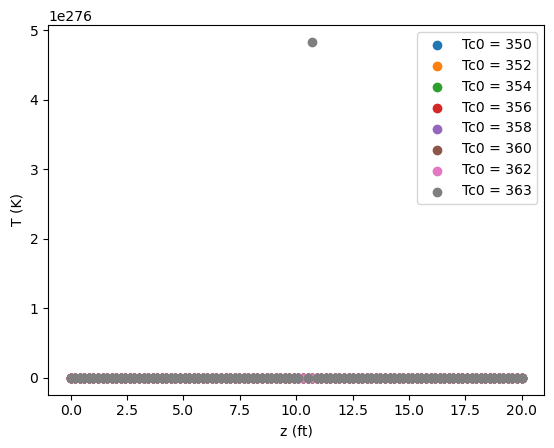

In [4]:
# define T horizon
dz = np.linspace(0, L, 100)

# loop through Tc0 values
Tc0_co = [350, 352, 354, 356, 358, 360, 362, 363]
solns = []
for Tc0 in Tc0_co:
    ic = np.array(Xi_0 + [T_R0, Tc0, MW_0, P_T0])
    y_co = odeint(odes, ic, dz, args=('cocurrent',))
    solns.append(y_co)
    plt.scatter(dz, y_co[:, 5], label = 'Tc0 = ' + str(Tc0))

plt.legend()
plt.xlabel('z (ft)')
plt.ylabel('T (K)')
plt.show()

In [ ]:
# Plot yeild VA v z

# loop through Tc0 values
Tc0_co = [350, 352, 354, 356, 358, 360, 362, 363]
solns = []
for Tc0 in Tc0_co:
    ic = np.array(Xi_0 + [T_R0, Tc0, MW_0, P_T0])
    y_co = odeint(odes, ic, dz, args=('cocurrent',))
    solns.append(y_co)
    plt.plot(dz, y_co[:, 2], label = 'Tc0 = ' + str(Tc0))

plt.xlabel('Reactor Length (ft)')
plt.ylabel('VA Yeild')
plt.legend()
plt.show()

In [ ]:
# Plot Tc vs. z

# loop through Tc0 values
Tc0_co = [350, 352, 354, 356, 358, 360, 362, 363]
solns = []
for Tc0 in Tc0_co:
    ic = np.array(Xi_0 + [T_R0, Tc0, MW_0, P_T0])
    y_co = odeint(odes, ic, dz, args=('cocurrent',))
    solns.append(y_co)
    plt.scatter(dz, y_co[:, 6], label = 'Tc0 = ' + str(Tc0))

plt.legend()
plt.xlabel('z (ft)')
plt.ylabel('T (K)')
plt.show()

In [ ]:
# # plot - Tr v z, for multiple Tc0 (350-364 for both)
# Tr_co = y_co[:, 5]
# Tc_co = y_co[:, 6]

# plt.plot(dz, Tr_co)


# # yeild, VA v z

# # Tc v z, for multiple Tc0

# # Tr_max v for multiple Tc_0 

# # sensitvity use np.gradient (slope of Tr_max v Tc)


# plt.plot(Tr_co, Tr_co)
# plt.savefig('Tr_co.png')